# Baseline Random Forest Classifier

This notebook builds and evaluates a baseline Random Forest classifier for soccer match prediction: Over/Under 2.5 goals (binary classification).

## Structure:
- **#0**: Setup and Data Loading
- **#1**: Baseline Model Training
- **#2**: Hyperparameter Tuning
- **#3**: Feature Importance Analysis
- **#4**: Learning Curves
- **#5**: Final Evaluation on Test Set

## #0: Setup and Data Loading

### #0.1: Import Required Libraries
Import all necessary libraries for model training, evaluation, and visualization.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.model_selection import learning_curve, GridSearchCV
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

/Users/ozetek/Documents/Škola/5. semestr/ML2/soccer-leagues-predictions/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### #0.2: Load Preprocessed Data
Load the baseline preprocessed data containing training, validation, and test sets.

In [2]:
with open('./processed/baseline_preprocessed.pkl', 'rb') as file:
    data = pickle.load(file)

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

In [3]:
# Check data shapes
print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")
print(f"\nClass distribution in training set:")
class_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
class_names = {0: 'Under 2.5 goals', 1: 'Over 2.5 goals'}
for idx, val in class_dist.items():
    print(f"{class_names[idx]}: {val:.4f}")

Training set: X=(20940, 344), y=(20940,)
Validation set: X=(7277, 344), y=(7277,)
Test set: X=(14376, 344), y=(14376,)

Class distribution in training set:
Under 2.5 goals: 0.5103
Over 2.5 goals: 0.4897


## #1: Baseline Model Training

### #1.1: Train Baseline Random Forest
Train an untuned Random Forest classifier with default parameters on the training set.

In [10]:
# Train baseline Random Forest with default parameters
baseline_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Training baseline Random Forest...")
baseline_rf.fit(X_train, y_train)
print("Training completed!")

Training baseline Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s


Training completed!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


### #1.2: Evaluate Baseline Model on Validation Set
Generate predictions and calculate performance metrics on the validation set.

In [11]:
def evaluate_model(model, X, y, dataset_name="Dataset"):
    """
    Evaluate model and return comprehensive metrics.
    """
    # Predictions
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y, y_pred, average='weighted', zero_division=0)
    
    # ROC-AUC for binary classification
    try:
        roc_auc = roc_auc_score(y, y_pred_proba[:, 1])
    except:
        roc_auc = None
    
    print(f"\n{'='*60}")
    print(f"Performance Metrics - {dataset_name}")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if roc_auc:
        print(f"ROC-AUC:   {roc_auc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y, y_pred, target_names=['Under 2.5', 'Over 2.5'], zero_division=0))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

# Evaluate on training set
baseline_train_results = evaluate_model(baseline_rf, X_train, y_train, "Baseline - Training Set")


Performance Metrics - Baseline - Training Set
Accuracy:  0.7131
Precision: 0.7182
Recall:    0.7131
F1-Score:  0.7106
ROC-AUC:   0.7974

Confusion Matrix:
[[8554 2132]
 [3876 6378]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.69      0.80      0.74     10686
    Over 2.5       0.75      0.62      0.68     10254

    accuracy                           0.71     20940
   macro avg       0.72      0.71      0.71     20940
weighted avg       0.72      0.71      0.71     20940



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


In [12]:
# Evaluate on validation set
baseline_val_results = evaluate_model(baseline_rf, X_val, y_val, "Baseline - Validation Set")


Performance Metrics - Baseline - Validation Set
Accuracy:  0.5409
Precision: 0.5447
Recall:    0.5409
F1-Score:  0.5364
ROC-AUC:   0.5651

Confusion Matrix:
[[1642 2062]
 [1279 2294]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.56      0.44      0.50      3704
    Over 2.5       0.53      0.64      0.58      3573

    accuracy                           0.54      7277
   macro avg       0.54      0.54      0.54      7277
weighted avg       0.54      0.54      0.54      7277



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


### #1.3: Visualize Confusion Matrix
Create a heatmap visualization of the confusion matrix for the validation set.

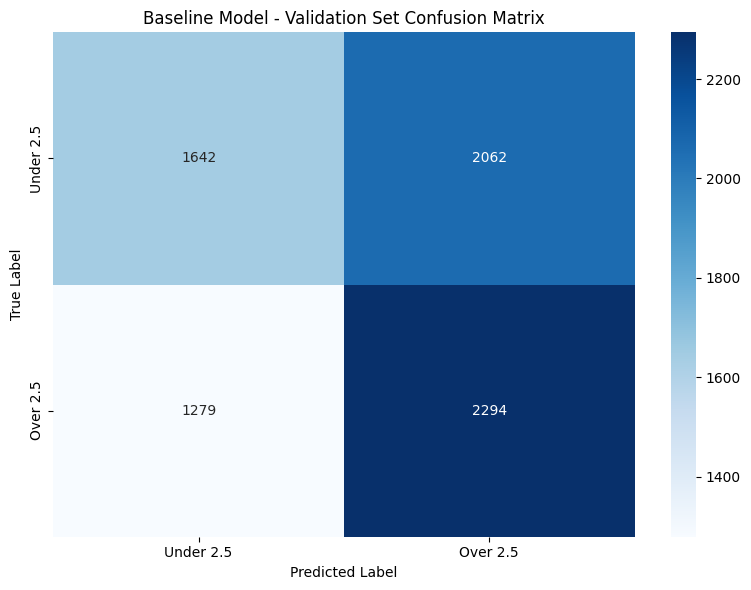

In [13]:
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """
    Plot confusion matrix as a heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Under 2.5', 'Over 2.5'],
                yticklabels=['Under 2.5', 'Over 2.5'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(baseline_val_results['confusion_matrix'], 
                     "Baseline Model - Validation Set Confusion Matrix")

## #2: Hyperparameter Tuning

### #2.1: Bayesian Optimization with Optuna
Use Optuna to perform Bayesian optimization to find optimal hyperparameters.

In [14]:
def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.
    """
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Train model
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    return f1

# Create study and optimize
print("Starting Bayesian Optimization with Optuna...")
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\nBest trial:")
print(f"  Value (F1-Score): {study.best_trial.value:.4f}")
print(f"  Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-11-11 13:34:54,759] A new study created in memory with name: no-name-c351978d-162c-4978-a4a4-237aeccaafba


Starting Bayesian Optimization with Optuna...


Best trial: 0. Best value: 0.531009:   2%|▏         | 1/50 [00:01<01:28,  1.81s/it]

[I 2025-11-11 13:34:56,572] Trial 0 finished with value: 0.531008640729311 and parameters: {'n_estimators': 250, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.531008640729311.


Best trial: 1. Best value: 0.56046:   4%|▍         | 2/50 [00:02<01:05,  1.36s/it] 

[I 2025-11-11 13:34:57,618] Trial 1 finished with value: 0.5604602057196808 and parameters: {'n_estimators': 383, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.5604602057196808.


Best trial: 1. Best value: 0.56046:   4%|▍         | 2/50 [00:07<02:48,  3.50s/it]


[W 2025-11-11 13:35:01,706] Trial 2 failed with parameters: {'n_estimators': 273, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/ozetek/Documents/Škola/5. semestr/ML2/soccer-leagues-predictions/.venv/lib/python3.13/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/5k/xsh6xzj10l121lg2lr_6rpkm0000gn/T/ipykernel_59263/1693403756.py", line 19, in objective
    model.fit(X_train, y_train)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^
  File "/Users/ozetek/Documents/Škola/5. semestr/ML2/soccer-leagues-predictions/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/ozetek/Documents/Škola/5. semestr/ML2/soccer-leagues-predictions/.venv/lib/python3.13/site-packages/sklearn/ensemble/_forest.

KeyboardInterrupt: 

### #2.2: Visualize Optuna Optimization History
Plot the optimization history to understand how the search progressed.

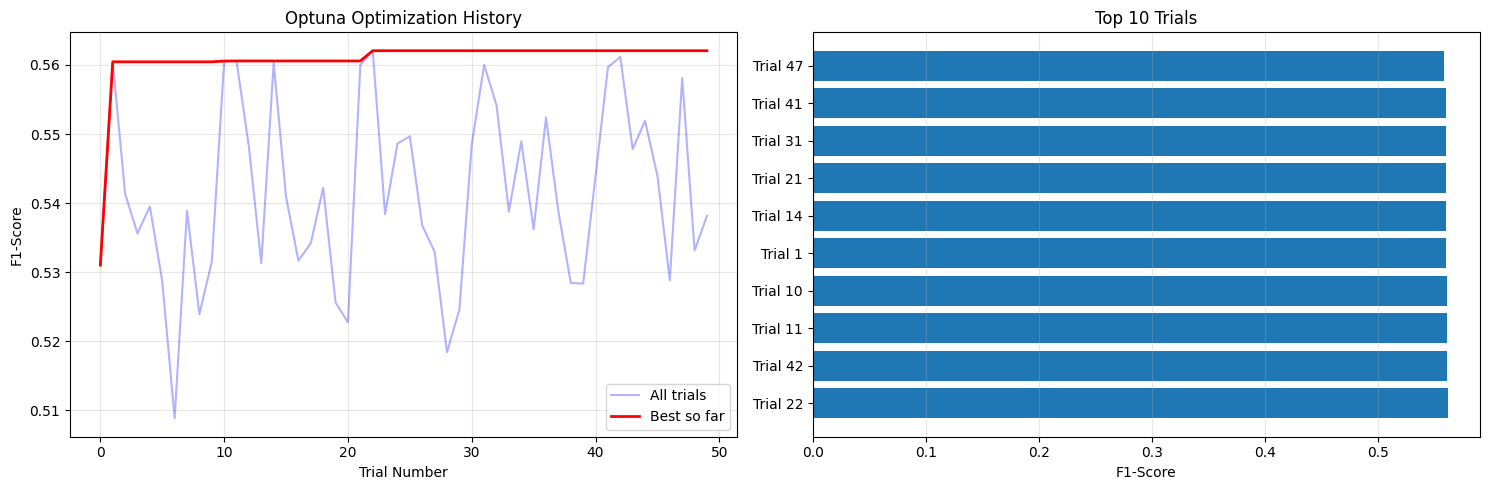

In [9]:
# Plot optimization history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot all trials
trials_df = study.trials_dataframe()
ax1.plot(trials_df['number'], trials_df['value'], 'b-', alpha=0.3, label='All trials')
ax1.plot(trials_df['number'], trials_df['value'].cummax(), 'r-', linewidth=2, label='Best so far')
ax1.set_xlabel('Trial Number')
ax1.set_ylabel('F1-Score')
ax1.set_title('Optuna Optimization History')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot top 10 trials
top_trials = trials_df.nlargest(10, 'value')
ax2.barh(range(len(top_trials)), top_trials['value'])
ax2.set_yticks(range(len(top_trials)))
ax2.set_yticklabels([f"Trial {int(t)}" for t in top_trials['number']])
ax2.set_xlabel('F1-Score')
ax2.set_title('Top 10 Trials')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### #2.3: Grid Search Refinement
Perform a focused grid search around the best parameters from Optuna to fine-tune.

In [10]:
# Get best parameters from Optuna
best_params = study.best_trial.params

# Define refined grid around best parameters
param_grid = {
    'n_estimators': [max(100, best_params['n_estimators'] - 50), 
                     best_params['n_estimators'], 
                     best_params['n_estimators'] + 50],
    'max_depth': [max(5, best_params['max_depth'] - 2), 
                  best_params['max_depth'], 
                  min(30, best_params['max_depth'] + 2)],
    'min_samples_split': [max(2, best_params['min_samples_split'] - 2), 
                          best_params['min_samples_split'], 
                          best_params['min_samples_split'] + 2],
    'min_samples_leaf': [max(1, best_params['min_samples_leaf'] - 1), 
                         best_params['min_samples_leaf'], 
                         best_params['min_samples_leaf'] + 1],
    'max_features': [best_params['max_features']],
    'bootstrap': [best_params['bootstrap']],
    'random_state': [42],
    'n_jobs': [-1]
}

print("Performing Grid Search refinement...")
print(f"Grid search space size: {np.prod([len(v) for v in param_grid.values() if len(v) > 1])} combinations")

# Combine train and validation for grid search (since we're using cv)
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([pd.Series(y_train), pd.Series(y_val)]).values

grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_val, y_train_val)

print(f"\nBest Grid Search F1-Score: {grid_search.best_score_:.4f}")
print(f"Best Grid Search Parameters:")
for key, value in grid_search.best_params_.items():
    print(f"  {key}: {value}")

Performing Grid Search refinement...
Grid search space size: 81 combinations
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=9, min_samples_split=18, n_estimators=410, n_jobs=-1, random_state=42; total time=  12.6s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=9, min_samples_split=18, n_estimators=410, n_jobs=-1, random_state=42; total time=  12.6s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=9, min_samples_split=18, n_estimators=460, n_jobs=-1, random_state=42; total time=  13.7s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=9, min_samples_split=18, n_estimators=410, n_jobs=-1, random_state=42; total time=  13.7s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=9, min_samples_split=18, n_estimators=460, n_jobs=-1, random_state=42; total time=  13.7s
[CV] END bootstrap=False, max_depth=

### #2.4: Train Final Tuned Model
Train the tuned Random Forest model with the best parameters from grid search.

In [11]:
# Use the best model from grid search
tuned_rf = grid_search.best_estimator_

print("Tuned Random Forest model trained successfully!")
print(f"Best parameters: {grid_search.best_params_}")

Tuned Random Forest model trained successfully!
Best parameters: {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 18, 'n_estimators': 510, 'n_jobs': -1, 'random_state': 42}


### #2.5: Compare Baseline vs Tuned Models
Evaluate and compare performance of baseline and tuned models on the validation set.

In [12]:
# Evaluate tuned model on validation set
tuned_val_results = evaluate_model(tuned_rf, X_val, y_val, "Tuned - Validation Set")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Baseline': [
        baseline_val_results['accuracy'],
        baseline_val_results['precision'],
        baseline_val_results['recall'],
        baseline_val_results['f1'],
        baseline_val_results['roc_auc']
    ],
    'Tuned': [
        tuned_val_results['accuracy'],
        tuned_val_results['precision'],
        tuned_val_results['recall'],
        tuned_val_results['f1'],
        tuned_val_results['roc_auc']
    ]
})

comparison_df['Improvement'] = comparison_df['Tuned'] - comparison_df['Baseline']
comparison_df['Improvement %'] = (comparison_df['Improvement'] / comparison_df['Baseline'] * 100).round(2)

print("\n" + "="*80)
print("Baseline vs Tuned Model Comparison (Validation Set)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


Performance Metrics - Tuned - Validation Set
Accuracy:  0.6019
Precision: 0.6065
Recall:    0.6019
F1-Score:  0.5950
ROC-AUC:   0.6419

Confusion Matrix:
[[2698 1006]
 [1891 1682]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.59      0.73      0.65      3704
    Over 2.5       0.63      0.47      0.54      3573

    accuracy                           0.60      7277
   macro avg       0.61      0.60      0.59      7277
weighted avg       0.61      0.60      0.60      7277


Baseline vs Tuned Model Comparison (Validation Set)
   Metric  Baseline    Tuned  Improvement  Improvement %
 Accuracy  0.524804 0.601896     0.077092          14.69
Precision  0.527448 0.606495     0.079047          14.99
   Recall  0.524804 0.601896     0.077092          14.69
 F1-Score  0.521208 0.595002     0.073794          14.16
  ROC-AUC  0.546017 0.641864     0.095847          17.55


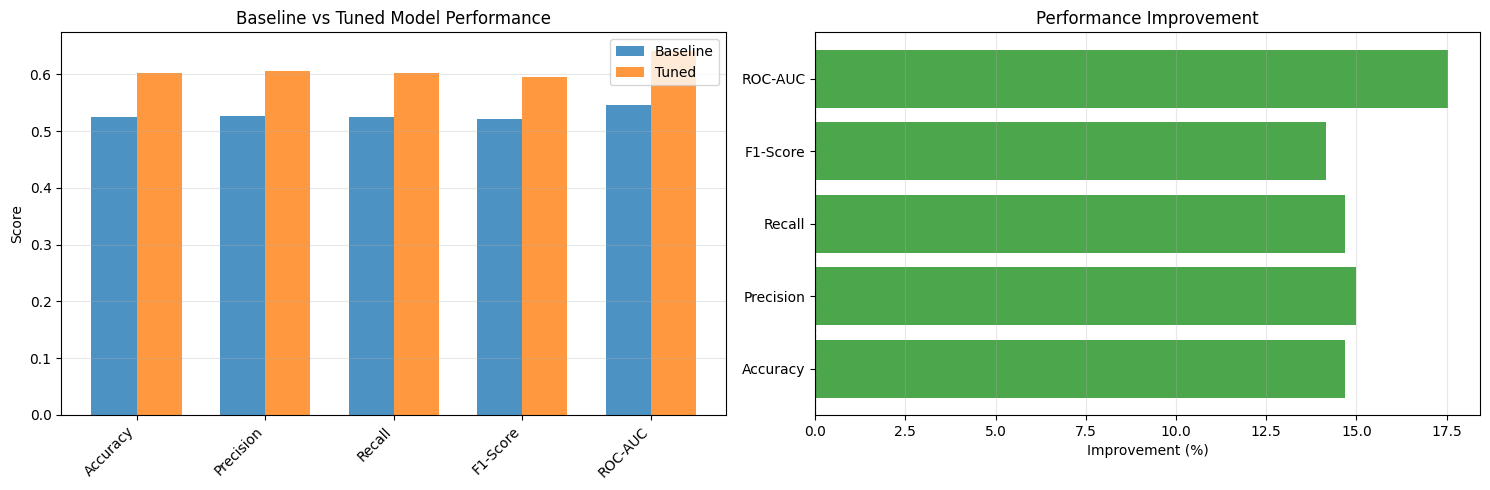

In [13]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot comparison
metrics = comparison_df['Metric'].tolist()
x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Baseline'], width, label='Baseline', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Tuned'], width, label='Tuned', alpha=0.8)
axes[0].set_ylabel('Score')
axes[0].set_title('Baseline vs Tuned Model Performance')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Improvement percentage
colors = ['green' if x > 0 else 'red' for x in comparison_df['Improvement %']]
axes[1].barh(metrics, comparison_df['Improvement %'], color=colors, alpha=0.7)
axes[1].set_xlabel('Improvement (%)')
axes[1].set_title('Performance Improvement')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## #3: Feature Importance Analysis

### #3.1: Calculate and Visualize Feature Importance
Analyze which features are most important for the tuned model's predictions.

Top 20 Most Important Features:
                        feature  importance
               HomeTeam_encoded    0.067384
               AwayTeam_encoded    0.061563
       combined_attack_strength    0.034470
home_home_scored_3plus_pct_2019    0.032144
 home_home_total_3plus_pct_2019    0.029637
      home_total_3plus_pct_2019    0.029578
     home_scored_3plus_pct_2019    0.028869
      away_total_3plus_pct_2019    0.027849
     home_scored_2plus_pct_2019    0.027750
     away_scored_3plus_pct_2019    0.020210
     home_scored_2plus_pct_2020    0.017982
     home_scored_3plus_pct_2020    0.017960
      home_total_2plus_pct_2019    0.017840
home_home_scored_2plus_pct_2019    0.017823
                        Div_SP2    0.017172
      away_total_3plus_pct_2020    0.016929
      away_total_2plus_pct_2019    0.015799
home_home_scored_3plus_pct_2020    0.015368
      home_total_3plus_pct_2020    0.014993
     away_scored_2plus_pct_2019    0.014931


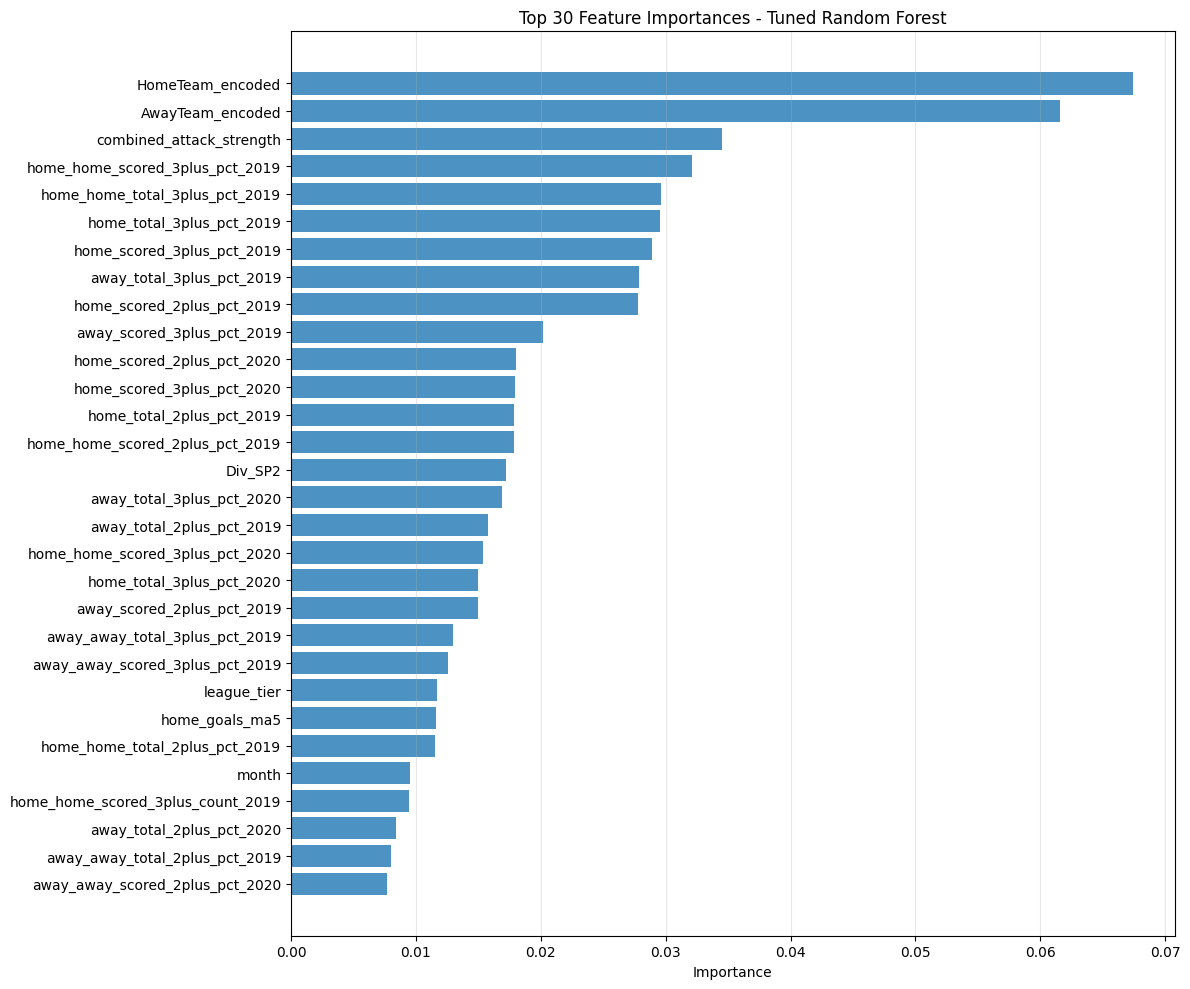

In [14]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': tuned_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Plot top 30 features
plt.figure(figsize=(12, 10))
top_n = 30
top_features = feature_importance.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'], alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances - Tuned Random Forest')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### #3.2: Feature Importance Distribution Analysis
Analyze the distribution of feature importances and cumulative importance.

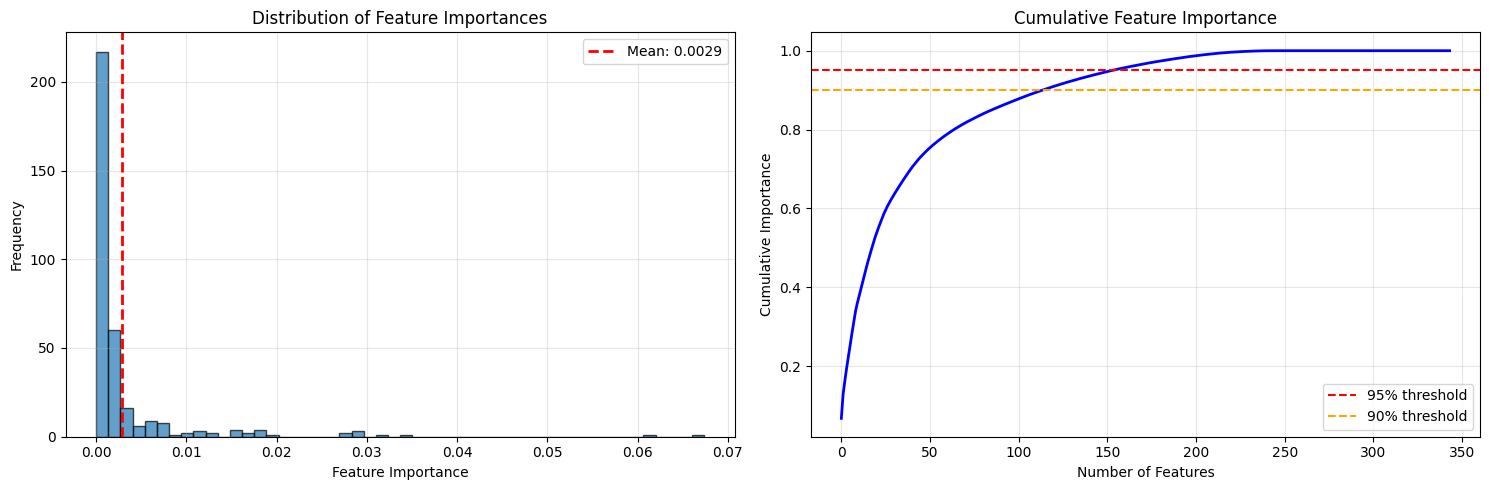


Feature Importance Summary:
  Total features: 344
  Features capturing 90% importance: 115 (33.4%)
  Features capturing 95% importance: 154 (44.8%)


In [15]:
# Calculate cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Importance distribution
ax1.hist(feature_importance['importance'], bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Feature Importance')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Feature Importances')
ax1.axvline(feature_importance['importance'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {feature_importance["importance"].mean():.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative importance
ax2.plot(range(len(feature_importance)), feature_importance['cumulative_importance'], 'b-', linewidth=2)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
ax2.axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Cumulative Importance')
ax2.set_title('Cumulative Feature Importance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Report how many features capture 90% and 95% of importance
n_features_90 = (feature_importance['cumulative_importance'] <= 0.90).sum() + 1
n_features_95 = (feature_importance['cumulative_importance'] <= 0.95).sum() + 1

print(f"\nFeature Importance Summary:")
print(f"  Total features: {len(feature_importance)}")
print(f"  Features capturing 90% importance: {n_features_90} ({n_features_90/len(feature_importance)*100:.1f}%)")
print(f"  Features capturing 95% importance: {n_features_95} ({n_features_95/len(feature_importance)*100:.1f}%)")

## #4: Learning Curves

### #4.1: Generate Learning Curves for Both Models
Plot learning curves to analyze training vs validation performance and identify overfitting.

Generating learning curves for baseline model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finis

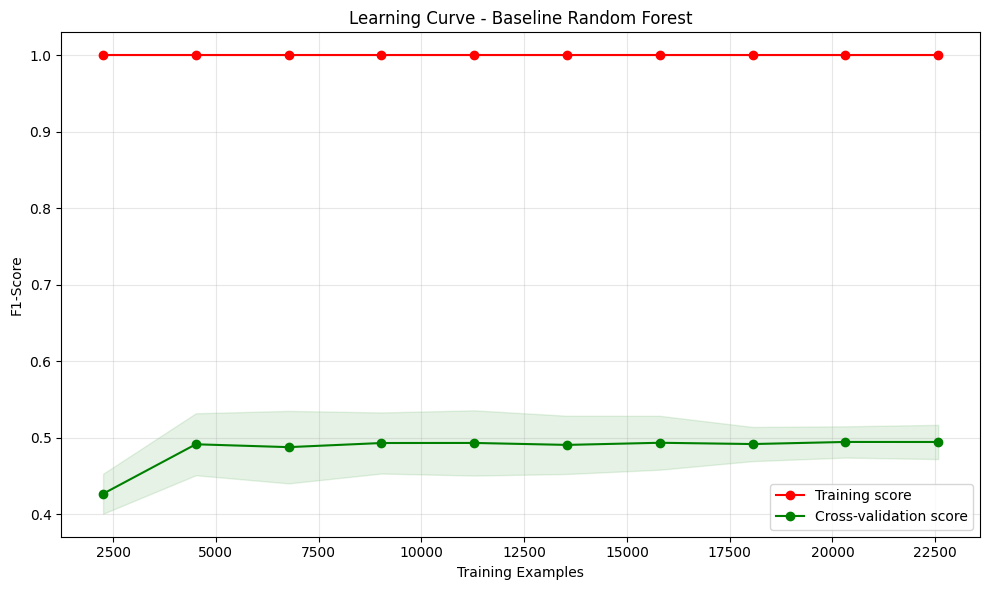

In [16]:
def plot_learning_curve(model, X, y, title, cv=5):
    """
    Generate and plot learning curves for a model.
    """
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, 
        cv=cv,
        scoring='f1_weighted',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.xlabel("Training Examples")
    plt.ylabel("F1-Score")
    plt.title(title)
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return train_scores_mean, val_scores_mean

# Generate learning curves for baseline model
print("Generating learning curves for baseline model...")
baseline_train_lc, baseline_val_lc = plot_learning_curve(
    baseline_rf, X_train_val, y_train_val, 
    "Learning Curve - Baseline Random Forest"
)

Generating learning curves for tuned model...


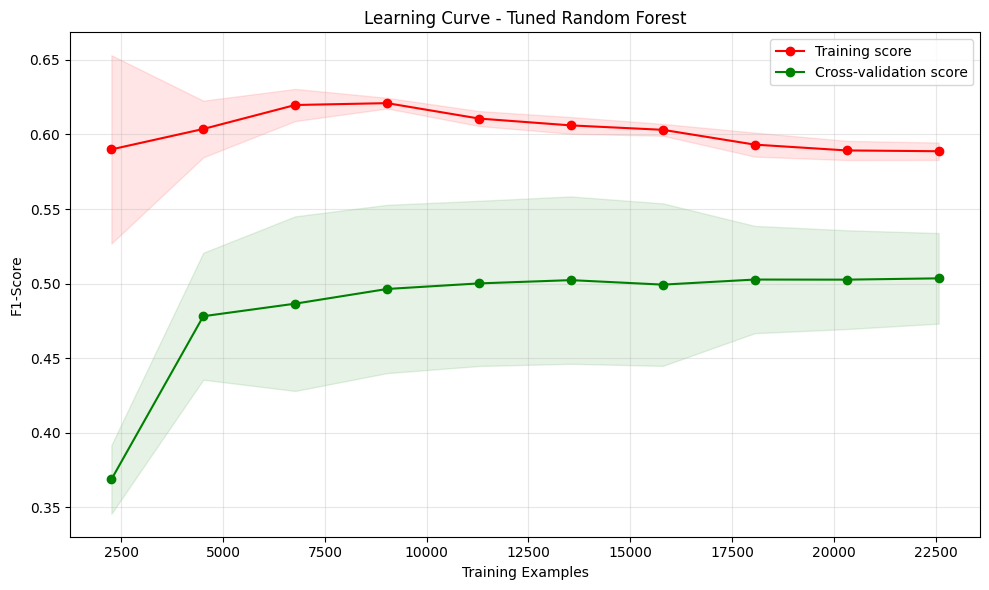

In [17]:
# Generate learning curves for tuned model
print("Generating learning curves for tuned model...")
tuned_train_lc, tuned_val_lc = plot_learning_curve(
    tuned_rf, X_train_val, y_train_val, 
    "Learning Curve - Tuned Random Forest"
)

## #5: Final Evaluation on Test Set

### #5.1: Evaluate Baseline Model on Test Set
Test the baseline model on the held-out test set to get final performance metrics.

In [18]:
# Evaluate baseline model on test set
baseline_test_results = evaluate_model(baseline_rf, X_test, y_test, "Baseline - Test Set")


Performance Metrics - Baseline - Test Set
Accuracy:  0.5254
Precision: 0.5233
Recall:    0.5254
F1-Score:  0.5218
ROC-AUC:   0.5350

Confusion Matrix:
[[3001 3910]
 [2913 4552]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.51      0.43      0.47      6911
    Over 2.5       0.54      0.61      0.57      7465

    accuracy                           0.53     14376
   macro avg       0.52      0.52      0.52     14376
weighted avg       0.52      0.53      0.52     14376



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


### #5.2: Evaluate Tuned Model on Test Set
Test the tuned model on the held-out test set to get final performance metrics.

In [19]:
# Evaluate tuned model on test set
tuned_test_results = evaluate_model(tuned_rf, X_test, y_test, "Tuned - Test Set")


Performance Metrics - Tuned - Test Set
Accuracy:  0.5467
Precision: 0.5536
Recall:    0.5467
F1-Score:  0.5426
ROC-AUC:   0.5719

Confusion Matrix:
[[4493 2418]
 [4098 3367]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.52      0.65      0.58      6911
    Over 2.5       0.58      0.45      0.51      7465

    accuracy                           0.55     14376
   macro avg       0.55      0.55      0.54     14376
weighted avg       0.55      0.55      0.54     14376



### #5.3: Final Comparison - Test Set Performance
Compare baseline and tuned model performance on the test set with visualizations.

In [20]:
# Create comprehensive comparison for test set
test_comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Baseline': [
        baseline_test_results['accuracy'],
        baseline_test_results['precision'],
        baseline_test_results['recall'],
        baseline_test_results['f1'],
        baseline_test_results['roc_auc']
    ],
    'Tuned': [
        tuned_test_results['accuracy'],
        tuned_test_results['precision'],
        tuned_test_results['recall'],
        tuned_test_results['f1'],
        tuned_test_results['roc_auc']
    ]
})

test_comparison_df['Improvement'] = test_comparison_df['Tuned'] - test_comparison_df['Baseline']
test_comparison_df['Improvement %'] = (test_comparison_df['Improvement'] / test_comparison_df['Baseline'] * 100).round(2)

print("\n" + "="*80)
print("FINAL COMPARISON: Baseline vs Tuned Model (Test Set)")
print("="*80)
print(test_comparison_df.to_string(index=False))
print("="*80)


FINAL COMPARISON: Baseline vs Tuned Model (Test Set)
   Metric  Baseline    Tuned  Improvement  Improvement %
 Accuracy  0.525390 0.546745     0.021355           4.06
Precision  0.523275 0.553643     0.030369           5.80
   Recall  0.525390 0.546745     0.021355           4.06
 F1-Score  0.521797 0.542570     0.020774           3.98
  ROC-AUC  0.534994 0.571912     0.036918           6.90


In [1]:
# Visualize test set comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Metrics comparison bar plot
metrics = test_comparison_df['Metric'].tolist()
x = np.arange(len(metrics))
width = 0.35

axes[0, 0].bar(x - width/2, test_comparison_df['Baseline'], width, label='Baseline', alpha=0.8)
axes[0, 0].bar(x + width/2, test_comparison_df['Tuned'], width, label='Tuned', alpha=0.8)
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Test Set: Baseline vs Tuned Model Performance')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Improvement percentage
colors = ['green' if x > 0 else 'red' for x in test_comparison_df['Improvement %']]
axes[0, 1].barh(metrics, test_comparison_df['Improvement %'], color=colors, alpha=0.7)
axes[0, 1].set_xlabel('Improvement (%)')
axes[0, 1].set_title('Test Set: Performance Improvement')
axes[0, 1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Baseline confusion matrix
sns.heatmap(baseline_test_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Under 2.5', 'Over 2.5'], yticklabels=['Under 2.5', 'Over 2.5'],
            ax=axes[1, 0])
axes[1, 0].set_title('Baseline Model - Test Set Confusion Matrix')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# 4. Tuned confusion matrix
sns.heatmap(tuned_test_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Under 2.5', 'Over 2.5'], yticklabels=['Under 2.5', 'Over 2.5'],
            ax=axes[1, 1])
axes[1, 1].set_title('Tuned Model - Test Set Confusion Matrix')
axes[1, 1].set_ylabel('True Label')
axes[1, 1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

### #5.4: Performance Summary Across All Sets
Compare model performance across training, validation, and test sets to check for overfitting.


PERFORMANCE SUMMARY ACROSS ALL DATASETS
   Dataset    Model  Accuracy  F1-Score  ROC-AUC
  Training Baseline  1.000000  1.000000 1.000000
Validation Baseline  0.524804  0.521208 0.546017
      Test Baseline  0.525390  0.521797 0.534994
  Training    Tuned       NaN       NaN      NaN
Validation    Tuned  0.601896  0.595002 0.641864
      Test    Tuned  0.546745  0.542570 0.571912


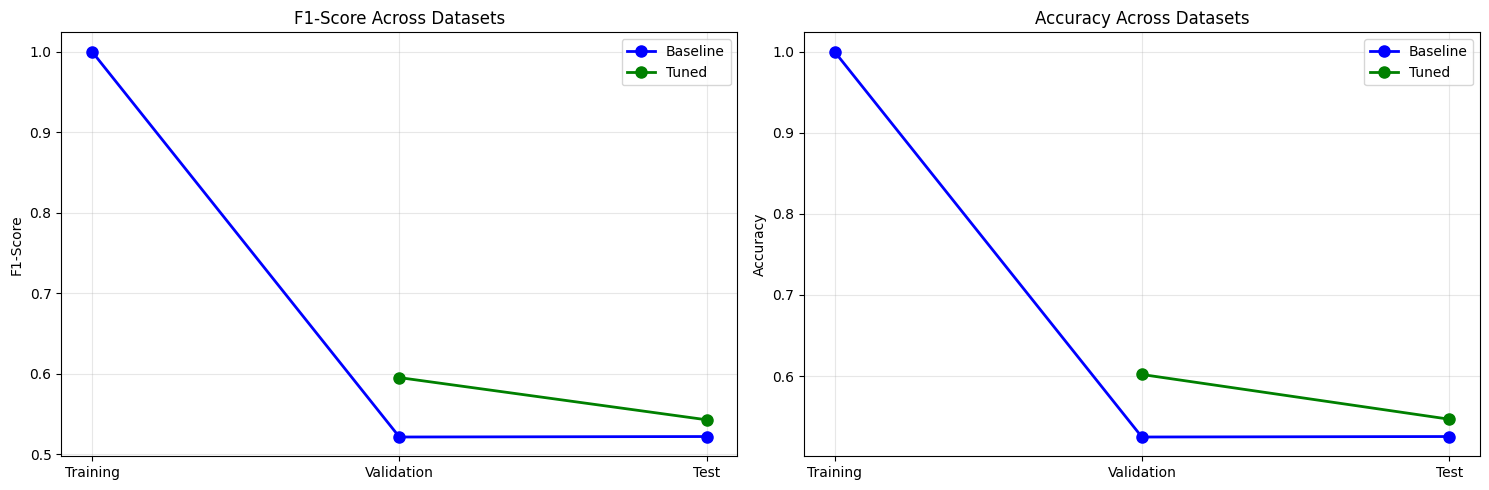

In [22]:
# Create comprehensive summary across all datasets
summary_data = {
    'Dataset': ['Training', 'Validation', 'Test'] * 2,
    'Model': ['Baseline'] * 3 + ['Tuned'] * 3,
    'Accuracy': [
        baseline_train_results['accuracy'],
        baseline_val_results['accuracy'],
        baseline_test_results['accuracy'],
        None,  # Tuned model not trained on original train set
        tuned_val_results['accuracy'],
        tuned_test_results['accuracy']
    ],
    'F1-Score': [
        baseline_train_results['f1'],
        baseline_val_results['f1'],
        baseline_test_results['f1'],
        None,
        tuned_val_results['f1'],
        tuned_test_results['f1']
    ],
    'ROC-AUC': [
        baseline_train_results['roc_auc'],
        baseline_val_results['roc_auc'],
        baseline_test_results['roc_auc'],
        None,
        tuned_val_results['roc_auc'],
        tuned_test_results['roc_auc']
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("PERFORMANCE SUMMARY ACROSS ALL DATASETS")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Plot performance across datasets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# F1-Score across datasets
baseline_f1 = [baseline_train_results['f1'], baseline_val_results['f1'], baseline_test_results['f1']]
tuned_f1 = [None, tuned_val_results['f1'], tuned_test_results['f1']]
datasets = ['Training', 'Validation', 'Test']

ax1.plot(datasets, baseline_f1, 'o-', linewidth=2, markersize=8, label='Baseline', color='blue')
ax1.plot(datasets[1:], [f for f in tuned_f1 if f is not None], 'o-', linewidth=2, markersize=8, label='Tuned', color='green')
ax1.set_ylabel('F1-Score')
ax1.set_title('F1-Score Across Datasets')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy across datasets
baseline_acc = [baseline_train_results['accuracy'], baseline_val_results['accuracy'], baseline_test_results['accuracy']]
tuned_acc = [None, tuned_val_results['accuracy'], tuned_test_results['accuracy']]

ax2.plot(datasets, baseline_acc, 'o-', linewidth=2, markersize=8, label='Baseline', color='blue')
ax2.plot(datasets[1:], [a for a in tuned_acc if a is not None], 'o-', linewidth=2, markersize=8, label='Tuned', color='green')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Across Datasets')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### #5.5: Save Best Model and Results
Save the tuned model and best parameters for future use.

In [24]:
# Save the tuned model
import joblib

model_save_path = './processed/tuned_random_forest_model.pkl'
joblib.dump(tuned_rf, model_save_path)
print(f"Tuned model saved to: {model_save_path}")

# Save the best parameters
params_save_path = './processed/best_rf_parameters.pkl'
best_params_final = grid_search.best_params_
joblib.dump(best_params_final, params_save_path)
print(f"Best parameters saved to: {params_save_path}")

# Save all results
results_save_path = './processed/baseline_rf_results.pkl'
results_dict = {
    'baseline_val': baseline_val_results,
    'baseline_test': baseline_test_results,
    'tuned_val': tuned_val_results,
    'tuned_test': tuned_test_results,
    'best_params': best_params_final,
    'feature_importance': feature_importance,
    'optuna_study': study
}
joblib.dump(results_dict, results_save_path)
print(f"All results saved to: {results_save_path}")

print("\n" + "="*80)
print("BEST MODEL CONFIGURATION")
print("="*80)
for key, value in best_params_final.items():
    print(f"  {key}: {value}")
print("="*80)

Tuned model saved to: ./processed/tuned_random_forest_model.pkl
Best parameters saved to: ./processed/best_rf_parameters.pkl
All results saved to: ./processed/baseline_rf_results.pkl

BEST MODEL CONFIGURATION
  bootstrap: False
  max_depth: 5
  max_features: sqrt
  min_samples_leaf: 9
  min_samples_split: 18
  n_estimators: 510
  n_jobs: -1
  random_state: 42


### #5.6: Final Summary and Conclusions
Display key findings and insights from the baseline Random Forest analysis.

In [25]:
print("\n" + "="*80)
print("BASELINE RANDOM FOREST - FINAL SUMMARY")
print("="*80)
print("\n1. MODEL PERFORMANCE ON TEST SET:")
print(f"   Baseline Model:")
print(f"     - Accuracy:  {baseline_test_results['accuracy']:.4f}")
print(f"     - F1-Score:  {baseline_test_results['f1']:.4f}")
print(f"     - ROC-AUC:   {baseline_test_results['roc_auc']:.4f}")
print(f"\n   Tuned Model:")
print(f"     - Accuracy:  {tuned_test_results['accuracy']:.4f}")
print(f"     - F1-Score:  {tuned_test_results['f1']:.4f}")
print(f"     - ROC-AUC:   {tuned_test_results['roc_auc']:.4f}")

improvement_f1 = ((tuned_test_results['f1'] - baseline_test_results['f1']) / baseline_test_results['f1'] * 100)
improvement_acc = ((tuned_test_results['accuracy'] - baseline_test_results['accuracy']) / baseline_test_results['accuracy'] * 100)

print(f"\n2. IMPROVEMENT THROUGH HYPERPARAMETER TUNING:")
print(f"   - Accuracy improved by:  {improvement_acc:+.2f}%")
print(f"   - F1-Score improved by:  {improvement_f1:+.2f}%")

print(f"\n3. TOP 5 MOST IMPORTANT FEATURES:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"   {idx+1}. {row['feature']}: {row['importance']:.4f}")

print(f"\n4. HYPERPARAMETER OPTIMIZATION:")
print(f"   - Optuna trials: 50")
print(f"   - Best Optuna F1-Score: {study.best_trial.value:.4f}")
print(f"   - Grid search refinement completed")
print(f"   - Final model trained on combined train+val set")

print(f"\n5. MODEL SAVED:")
print(f"   - Model: {model_save_path}")
print(f"   - Parameters: {params_save_path}")
print(f"   - Results: {results_save_path}")

print("\n" + "="*80)
print("Analysis Complete!")
print("="*80)


BASELINE RANDOM FOREST - FINAL SUMMARY

1. MODEL PERFORMANCE ON TEST SET:
   Baseline Model:
     - Accuracy:  0.5254
     - F1-Score:  0.5218
     - ROC-AUC:   0.5350

   Tuned Model:
     - Accuracy:  0.5467
     - F1-Score:  0.5426
     - ROC-AUC:   0.5719

2. IMPROVEMENT THROUGH HYPERPARAMETER TUNING:
   - Accuracy improved by:  +4.06%
   - F1-Score improved by:  +3.98%

3. TOP 5 MOST IMPORTANT FEATURES:
   322. HomeTeam_encoded: 0.0674
   323. AwayTeam_encoded: 0.0616
   316. combined_attack_strength: 0.0345
   54. home_home_scored_3plus_pct_2019: 0.0321
   70. home_home_total_3plus_pct_2019: 0.0296

4. HYPERPARAMETER OPTIMIZATION:
   - Optuna trials: 50
   - Best Optuna F1-Score: 0.5621
   - Grid search refinement completed
   - Final model trained on combined train+val set

5. MODEL SAVED:
   - Model: ./processed/tuned_random_forest_model.pkl
   - Parameters: ./processed/best_rf_parameters.pkl
   - Results: ./processed/baseline_rf_results.pkl

Analysis Complete!
